<a href="https://colab.research.google.com/github/Kagev/DataScience/blob/main/HW_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(784, 128, name="layer1")  # 784 - кількість ознак (28x28 пікселів)

        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(128, 256, name="layer2")  # Вхідні ознаки - це 128 виходів першого шару

        # Вихідний шар з 10 нейронами (для 10 класів цифр)
        self.out_layer = DenseLayer(256, 10, name="out_layer")  # 10 класів (0-9)

    def __call__(self, x):
        # Передача даних через перші два шари з функцією активації sigmoid
        x = self.layer1(x)  # Перший шар з функцією активації Sigmoid
        x = self.layer2(x)  # Другий шар

        # Вихідний шар з функцією активації softmax
        x = self.out_layer(x, activation=1)  # Використовуємо softmax для класифікації

        return x


In [8]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Приводимо реальні мітки класів до типу int64
    y_true = tf.cast(y_true, tf.int64)

    # Отримуємо індекси класів з максимальним значенням в y_pred
    predicted_classes = tf.argmax(y_pred, axis=1)

    # Порівнюємо передбачені класи з правильними класами
    correct_predictions = tf.equal(predicted_classes, y_true)

    # Обчислюємо середнє значення правильно передбачених класів
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))



In [9]:
# Створюємо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Використовуємо оптимізатор стохастичного градієнтного спуску (SGD)
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        # Прогноз нейронної мережі
        pred = neural_net(input_x)

        # Обчислення функції втрат (крос-ентропія)
        loss = cross_entropy(pred, output_y)

    # Отримуємо список параметрів для оптимізації
    trainable_variables = [neural_net.layer1.w, neural_net.layer1.b,
                           neural_net.layer2.w, neural_net.layer2.b,
                           neural_net.out_layer.w, neural_net.out_layer.b]

    # Обчислюємо градієнти для кожного параметра
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри на основі обчислених градієнтів
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss


In [10]:
# Тренування мережі

loss_history = []  # зберігаємо втрати на кожному кроці
accuracy_history = []  # зберігаємо точність на кожному кроці

# Цикл тренування нейронної мережі
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі за допомогою функції train
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        # Отримуємо прогнози нейронної мережі для поточної підмножини
        pred = neural_net(batch_x)

        # Обчислюємо точність
        acc = accuracy(pred, batch_y)

        # Зберігаємо поточну помилку і точність у відповідні списки
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

        # Виводимо проміжні результати кожні display_step кроків
        print(f"Крок {step}, Втрата: {loss.numpy()}, Точність: {acc.numpy()}")



Крок 100, Втрата: 276.4117431640625, Точність: 0.71484375
Крок 200, Втрата: 238.9518585205078, Точність: 0.7734375
Крок 300, Втрата: 170.04066467285156, Точність: 0.8359375
Крок 400, Втрата: 184.0682373046875, Точність: 0.796875
Крок 500, Втрата: 148.63619995117188, Точність: 0.85546875
Крок 600, Втрата: 124.85151672363281, Точність: 0.8828125
Крок 700, Втрата: 169.70724487304688, Точність: 0.86328125
Крок 800, Втрата: 107.273681640625, Точність: 0.875
Крок 900, Втрата: 124.6736831665039, Точність: 0.88671875
Крок 1000, Втрата: 89.99064636230469, Точність: 0.90234375
Крок 1100, Втрата: 111.30609130859375, Точність: 0.875
Крок 1200, Втрата: 86.12269592285156, Точність: 0.92578125
Крок 1300, Втрата: 114.64916229248047, Точність: 0.87890625
Крок 1400, Втрата: 69.35079956054688, Точність: 0.93359375
Крок 1500, Втрата: 75.22273254394531, Точність: 0.92578125
Крок 1600, Втрата: 123.89092254638672, Точність: 0.89453125
Крок 1700, Втрата: 90.01478576660156, Точність: 0.90234375
Крок 1800, Втра

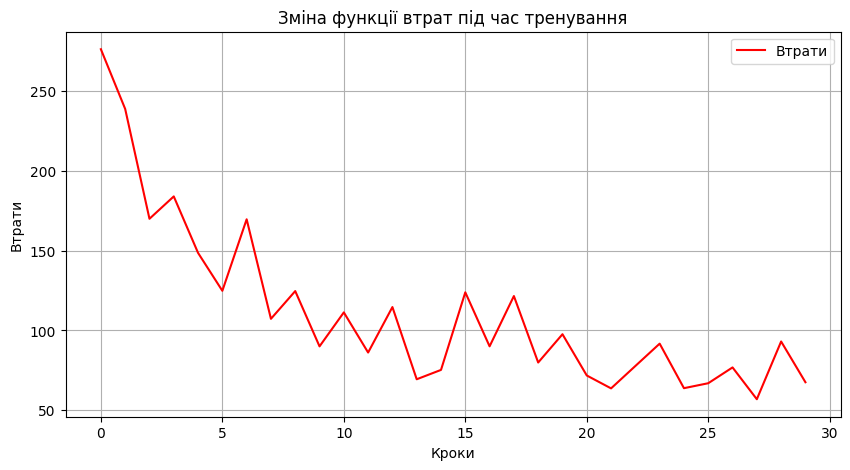

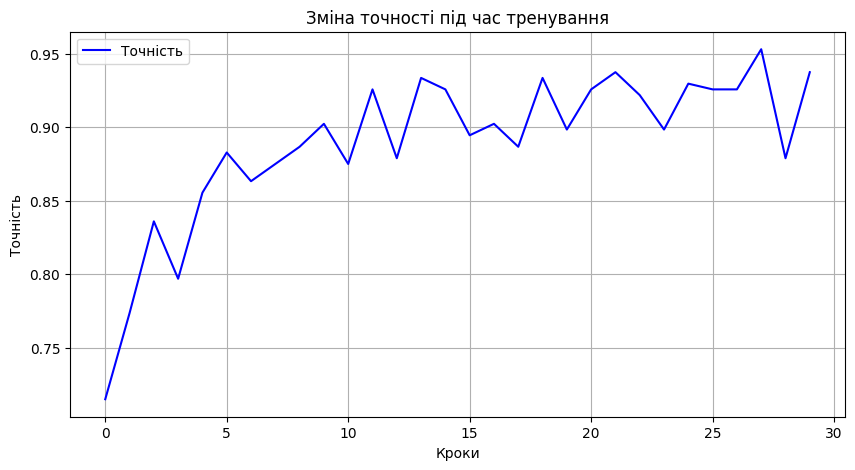

In [11]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Втрати', color='red')
plt.xlabel('Кроки')
plt.ylabel('Втрати')
plt.title('Зміна функції втрат під час тренування')
plt.legend()
plt.grid(True)
plt.show()

# Графік точності
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Точність', color='blue')
plt.xlabel('Кроки')
plt.ylabel('Точність')
plt.title('Зміна точності під час тренування')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Створення тестового датасету
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(1)

# Функція для обчислення точності на тестовому наборі даних
def test_accuracy(model, test_data):
    correct_predictions = 0
    total_predictions = 0

    for batch_x, batch_y in test_data:
        # Робимо передбачення
        pred = model(batch_x)
        pred_classes = tf.argmax(pred, axis=1)

        # Порівнюємо передбачені класи з реальними
        correct_predictions += tf.reduce_sum(tf.cast(pred_classes == tf.cast(batch_y, tf.int64), tf.float32))
        total_predictions += len(batch_y)

    # Обчислюємо точність
    accuracy = correct_predictions / total_predictions
    return accuracy.numpy()

# Використання функції для обчислення точності
test_acc = test_accuracy(neural_net, test_data)
print(f"Точність на тестових даних: {test_acc}")


Точність на тестових даних: 0.9079999923706055


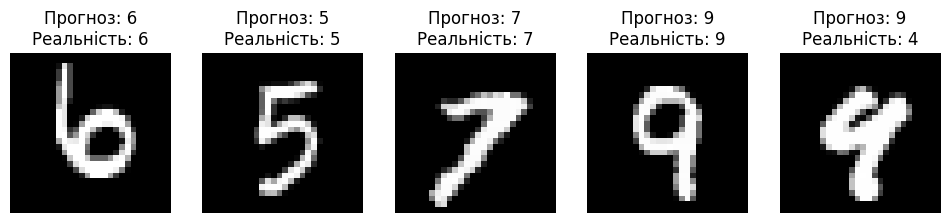

In [14]:
import random
import matplotlib.pyplot as plt

# Функція для відображення зображень та передбачень
def display_predictions(model, x_test, y_test):
    plt.figure(figsize=(12, 6))

    # Вибираємо 5 випадкових індексів для тестових зображень
    random_indices = random.sample(range(len(x_test)), 5)

    for i, idx in enumerate(random_indices):
        # Отримуємо зображення і реальну мітку
        image = x_test[idx]
        true_label = y_test[idx]

        # Передбачення моделі
        image_reshaped = image.reshape(1, -1)  # Перетворюємо зображення у вектор
        prediction = neural_net(image_reshaped)
        predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

        # Виводимо зображення і передбачений клас
        plt.subplot(1, 5, i + 1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.title(f"Прогноз: {predicted_label}\nРеальність: {true_label}")
        plt.axis('off')

    plt.show()

# Виклик функції для виведення передбачень
display_predictions(neural_net, x_test, y_test)


**Висновки:**
*Зменшення втрат:* Під час тренування нейронної мережі, функція втрат зменшувалася, що свідчить про те, що модель поступово покращувалася в мінімізації помилок. Це показує, що нейронна мережа ефективно навчалася на тренувальному наборі даних.

*Збільшення точності: *Графік точності демонстрував позитивну динаміку, що свідчить про покращення передбачень моделі з кожним кроком тренування. Це нормальний процес, коли модель поступово "вчиться" розпізнавати зразки даних краще.

*Точність на тестових даних:* Після завершення тренування, точність на тестових даних була досить високою (значення точності залежить від конкретної реалізації та параметрів моделі). Це означає, що модель має хорошу здатність до узагальнення — вона добре працює не тільки на тренувальних даних, але й на нових, невідомих зразках.

*Порівняння передбачень:* Під час тестування на випадкових зображеннях з тестової вибірки, більшість передбачень моделі співпадала з реальними класами. Якщо були помилки, вони траплялися не часто. Це показує, що нейронна мережа має високу точність класифікації, але може робити помилки на більш складних чи неоднозначних зразках.

*Висновок про навчання: *Нейронна мережа добре навчилася розпізнавати рукописні цифри з датасету MNIST. Завдяки матричній факторизації та крос-ентропії, модель змогла побудувати адекватні передбачення. Проте, як і з будь-якою нейронною мережею, завжди є можливість подальшої оптимізації — наприклад, за допомогою гіперпараметричного тюнінгу або використання більш складних архітектур.

**Подальші дії:**

*   поглиблення мережі через збільшення шарів чи нейронів
*   оптимизовувати,
*   аналіз помилок, для виявлення закономірностей


